In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# # !pip install torch

In [2]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from matplotlib import pyplot as plt
import random
import copy
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from numpy import linalg as LA
from tabulate import tabulate
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
gamma = 0
gamma

0

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}
fg_used = '012'
fg1, fg2, fg3 = 0,1,2


all_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
background_classes = all_classes - foreground_classes
background_classes


{'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

In [7]:
dataiter = iter(trainloader)
true_train_background_data=[]
true_train_background_label=[]
true_train_foreground_data=[]
true_train_foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      true_train_background_data.append(img)
      true_train_background_label.append(labels[j])
    else:
      img = images[j].tolist()
      true_train_foreground_data.append(img)
      true_train_foreground_label.append(labels[j])
            
true_train_foreground_data = torch.tensor(true_train_foreground_data)
true_train_foreground_label = torch.tensor(true_train_foreground_label)
true_train_background_data = torch.tensor(true_train_background_data)
true_train_background_label = torch.tensor(true_train_background_label)
    

In [8]:
true_train = trainset.data

In [9]:
train_label = trainset.targets

In [10]:
true_train_cifar_norm=[]
for i in range(len(true_train)):
  true_train_cifar_norm.append(LA.norm(true_train[i]))

In [11]:
len(true_train_cifar_norm)

50000

In [12]:
def plot_hist(values):
  plt.hist(values, density=True, bins=200)  # `density=False` would make counts
  plt.ylabel('NORM')
  plt.xlabel('Data');

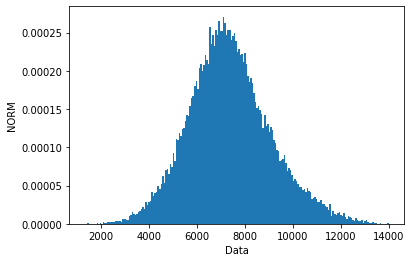

In [13]:
plot_hist(true_train_cifar_norm)

In [14]:
true_train.shape

(50000, 32, 32, 3)

In [15]:
train = np.reshape(true_train, (50000,3072))
train.shape, true_train.shape

((50000, 3072), (50000, 32, 32, 3))

In [16]:
u, s, vh = LA.svd(train, full_matrices= False)

In [17]:
u.shape , s.shape, vh.shape

((50000, 3072), (3072,), (3072, 3072))

In [18]:
s

array([1.55289927e+06, 2.82437414e+05, 2.17772149e+05, ...,
       7.31736954e+01, 7.23349722e+01, 7.18349192e+01])

In [19]:
vh

array([[-0.01984194, -0.02066161, -0.02037075, ..., -0.01879724,
        -0.01874038, -0.01729938],
       [-0.02488245, -0.02705999, -0.03195926, ...,  0.01262528,
         0.01096339,  0.00766722],
       [-0.0159231 , -0.01437591, -0.01281541, ..., -0.02971411,
        -0.0283376 , -0.02749635],
       ...,
       [-0.00449998,  0.00770844, -0.00281931, ..., -0.00013103,
        -0.00080887,  0.00071151],
       [ 0.00433324, -0.00629207,  0.00181791, ..., -0.00168695,
         0.00131196,  0.00052667],
       [-0.00574169,  0.00783184, -0.00186197, ...,  0.00511688,
        -0.00678068,  0.00138508]])

In [20]:
dir = vh[0:10,:]
dir

array([[-0.01984194, -0.02066161, -0.02037075, ..., -0.01879724,
        -0.01874038, -0.01729938],
       [-0.02488245, -0.02705999, -0.03195926, ...,  0.01262528,
         0.01096339,  0.00766722],
       [-0.0159231 , -0.01437591, -0.01281541, ..., -0.02971411,
        -0.0283376 , -0.02749635],
       ...,
       [-0.02951743, -0.02937473, -0.03039219, ..., -0.02521525,
        -0.02499111, -0.02603696],
       [ 0.01470676,  0.01439471,  0.01525553, ...,  0.02250098,
         0.02203123,  0.02426003],
       [-0.01884432, -0.01897853, -0.01804426, ...,  0.01736868,
         0.01658565,  0.01618766]])

In [21]:
u1 = dir[0,:]
u2 = dir[1,:]
u3 = dir[2,:]

In [22]:
u1

array([-0.01984194, -0.02066161, -0.02037075, ..., -0.01879724,
       -0.01874038, -0.01729938])

In [23]:
u2

array([-0.02488245, -0.02705999, -0.03195926, ...,  0.01262528,
        0.01096339,  0.00766722])

In [24]:
u3

array([-0.0159231 , -0.01437591, -0.01281541, ..., -0.02971411,
       -0.0283376 , -0.02749635])

In [25]:
len(train_label)

50000

In [26]:
def is_equal(x1, x2):
  cnt=0
  for i in range(len(x1)):
    if(x1[i] == x2[i]):
      cnt+=1
  return cnt

In [27]:
def add_noise_cifar(train, label, gamma, fg1,fg2,fg3):
  cnt=0

  for i in range(len(label)):
    x = train[i]
    if(label[i] == fg1):
      train[i] = train[i] + gamma * LA.norm(train[i]) * u1
      cnt+=1

    if(label[i] == fg2):
      train[i] = train[i] + gamma * LA.norm(train[i]) * u2
      cnt+=1

    if(label[i] == fg3):
      train[i] = train[i] + gamma * LA.norm(train[i]) * u3
      cnt+=1
    y = train[i]

  print("total modified",cnt)

  return train

total modified 15000
remain same 50000


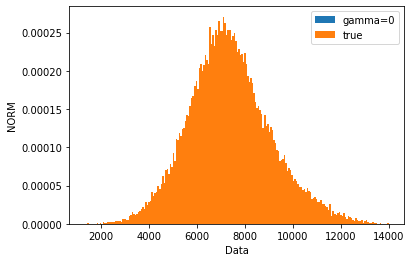

In [28]:
noise_train = np.reshape(true_train, (50000,3072))
noise_train = add_noise_cifar(noise_train, train_label, gamma , fg1,fg2,fg3)
noise_train_cifar_norm=[]
for i in range(len(noise_train)):
  noise_train_cifar_norm.append(LA.norm(noise_train[i]))
plt.hist(noise_train_cifar_norm, density=True, bins=200,label='gamma='+str(gamma))  # `density=False` would make counts
plt.hist(true_train_cifar_norm, density=True, bins=200,label='true') 
plt.ylabel('NORM')
plt.xlabel('Data')
plt.legend()
print("remain same",is_equal(noise_train_cifar_norm,true_train_cifar_norm))

In [29]:
noise_train.shape, trainset.data.shape

((50000, 3072), (50000, 32, 32, 3))

In [30]:
noise_train = np.reshape(noise_train, (50000,32, 32, 3))
noise_train.shape

(50000, 32, 32, 3)

In [31]:
trainset.data = noise_train

In [32]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):   #5000*batch_size = 50000 data points
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [33]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, axes = (1, 2, 0)))
  plt.show()

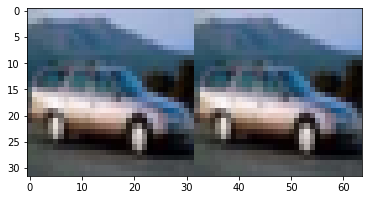

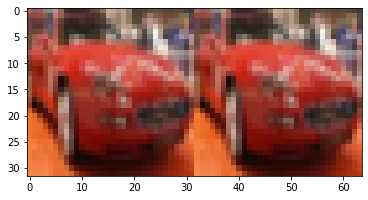

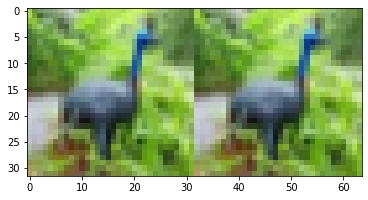

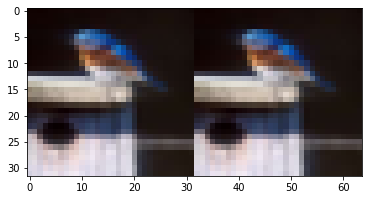

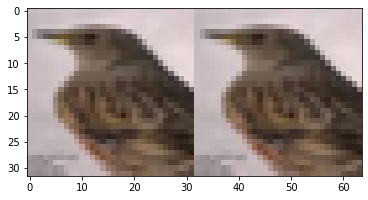

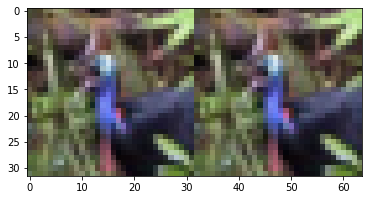

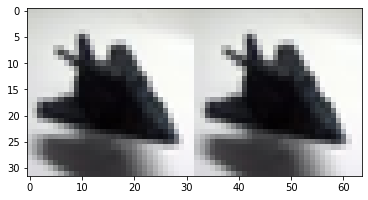

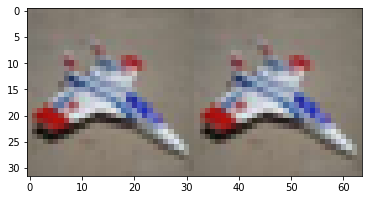

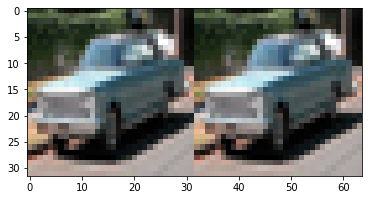

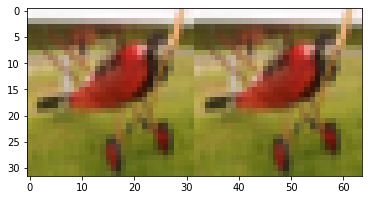

In [34]:
import random
for i in range(10):
  random.seed(i)
  a = np.random.randint(0,10000)
  img1 = torch.cat((true_train_foreground_data[i], foreground_data[i]),2)
  imshow(img1)

In [35]:
def plot_vectors(u1,u2,u3):
  img = np.reshape(u1,(3,32,32))
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  print("vector u1 norm",LA.norm(img))
  plt.figure(1)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title("vector u1")

  img = np.reshape(u2,(3,32,32))
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  print("vector u2 norm",LA.norm(img))
  plt.figure(2)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title("vector u2")

  img = np.reshape(u3,(3,32,32))
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  print("vector u3 norm",LA.norm(img))
  plt.figure(3)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title("vector u3")
  plt.show()

vector u1 norm 27.214629939250965
vector u2 norm 27.750348494199738
vector u3 norm 27.725709222404316


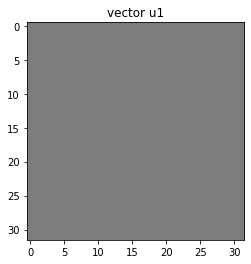

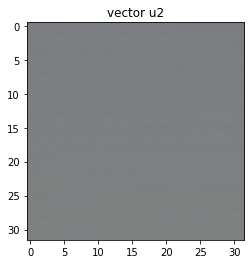

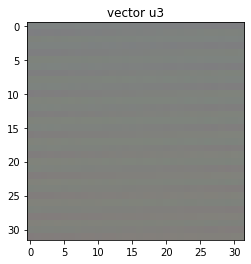

In [36]:
plot_vectors(u1,u2,u3)

In [37]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]  #-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [38]:
desired_num = 10000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  np.random.seed(35000 + i)
  bg_idx = np.random.randint(0,35000,8)
  np.random.seed(15000 + i)
  fg_idx = np.random.randint(0,15000)
  # fg = np.random.randint(0,9)
  fg = 0
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

In [39]:
del foreground_data
del foreground_label
del background_data
del background_label

In [40]:
# path = "/content/drive/My Drive/Research/testing classify on diff focus nets/give weightage to random image/"
# path = "/content/drive/My Drive/Research/Experiments on CIFAR mosaic/Exp_1_Attention_models_on _90k_mosaic_mini_inception/weights/"

In [41]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  cnt = 0
  counter = np.array([0,0,0,0,0,0,0,0,0])
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([3, 32,32], dtype=torch.float64)
    np.random.seed(dataset_number*10000 + i)
    give_pref = foreground_index[i] #np.random.randint(0,9)
    # print("outside", give_pref,foreground_index[i])
    for j in range(9):
      if j == give_pref:
        img = img + mosaic_dataset[i][j]*dataset_number/9
      else :
        img = img + mosaic_dataset[i][j]*(9-dataset_number)/(8*9)

    if give_pref == foreground_index[i] :
      # print("equal are", give_pref,foreground_index[i])
      cnt += 1
      counter[give_pref] += 1
    else :
      counter[give_pref] += 1

    avg_image_dataset.append(img)

  print("number of correct averaging happened for dataset "+str(dataset_number)+" is "+str(cnt)) 
  print("the averaging are done as ", counter) 
  return avg_image_dataset , labels , foreground_index
        
  

In [42]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 1)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 2)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 3)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 4)
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 5)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 6)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 7)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx , 8)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images, mosaic_label, fore_idx, 9)



number of correct averaging happened for dataset 1 is 10000
the averaging are done as  [10000     0     0     0     0     0     0     0     0]
number of correct averaging happened for dataset 2 is 10000
the averaging are done as  [10000     0     0     0     0     0     0     0     0]
number of correct averaging happened for dataset 3 is 10000
the averaging are done as  [10000     0     0     0     0     0     0     0     0]
number of correct averaging happened for dataset 4 is 10000
the averaging are done as  [10000     0     0     0     0     0     0     0     0]
number of correct averaging happened for dataset 5 is 10000
the averaging are done as  [10000     0     0     0     0     0     0     0     0]
number of correct averaging happened for dataset 6 is 10000
the averaging are done as  [10000     0     0     0     0     0     0     0     0]
number of correct averaging happened for dataset 7 is 10000
the averaging are done as  [10000     0     0     0     0     0     0     0     0]

In [43]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [44]:
batch = 256
epochs = 300

# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)

testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

In [45]:
class Conv_module(nn.Module):
    def __init__(self,inp_ch,f,s,k,pad):
        super(Conv_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.s = s 
        self.k = k 
        self.pad = pad
        
        
        self.conv = nn.Conv2d(self.inp_ch,self.f,k,stride=s,padding=self.pad)
        self.bn = nn.BatchNorm2d(self.f)
        self.act = nn.ReLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [46]:
class inception_module(nn.Module):
    def __init__(self,inp_ch,f0,f1):
        super(inception_module, self).__init__()
        self.inp_ch = inp_ch
        self.f0 = f0
        self.f1 = f1
        
        
        
        self.conv1 = Conv_module(self.inp_ch,self.f0,1,1,pad=0)
        self.conv3 = Conv_module(self.inp_ch,self.f1,1,3,pad=1)
        #self.conv1 = nn.Conv2d(3,self.f0,1)
        #self.conv3 = nn.Conv2d(3,self.f1,3,padding=1)
    def forward(self,x):
        x1 = self.conv1.forward(x)
        x3 = self.conv3.forward(x)
        #print(x1.shape,x3.shape)
        
        x = torch.cat((x1,x3),dim=1)
        
    
        return x

In [47]:
class downsample_module(nn.Module):
    def __init__(self,inp_ch,f):
        super(downsample_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.conv = Conv_module(self.inp_ch,self.f,2,3,pad=0)
        self.pool = nn.MaxPool2d(3,stride=2,padding=0)
    def forward(self,x):
        x1 = self.conv(x)
        #print(x1.shape)
        x2 = self.pool(x)
        #print(x2.shape)
        x = torch.cat((x1,x2),dim=1)
        
        return x,x1

In [48]:
class inception_net(nn.Module):
    def __init__(self):
        super(inception_net,self).__init__()
        self.conv1 = Conv_module(3,96,1,3,0)
        
        self.incept1 = inception_module(96,32,32)
        self.incept2 = inception_module(64,32,48)
        
        self.downsample1 = downsample_module(80,80)
        
        self.incept3 = inception_module(160,112,48)
        self.incept4 = inception_module(160,96,64)
        self.incept5 = inception_module(160,80,80)
        self.incept6 = inception_module(160,48,96)
        
        self.downsample2 = downsample_module(144,96)
        
        self.incept7 = inception_module(240,176,60)
        self.incept8 = inception_module(236,176,60)
        
        self.pool = nn.AvgPool2d(5)
        
        
        
        self.linear = nn.Linear(236,3)
    def forward(self,x):
        x = self.conv1.forward(x)
        #act1 = x
        
        x = self.incept1.forward(x)
        #act2 = x
        
        x = self.incept2.forward(x)
        #act3 = x
        
        x,act4 = self.downsample1.forward(x)
        
        x = self.incept3.forward(x)
        #act5 = x
        
        x = self.incept4.forward(x)
        #act6 = x
        
        x = self.incept5.forward(x)
        #act7 = x
        
        x = self.incept6.forward(x)
        #act8 = x
        
        x,act9 = self.downsample2.forward(x)
        
        x = self.incept7.forward(x)
        #act10 = x
        x = self.incept8.forward(x)
        #act11 = x
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,1*1*236)
        x = self.linear(x) 
        return x

In [49]:
def test_all(number, testloader,inc):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= inc(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test dataset %d: %d %%' % (number , 100 * correct / total))

In [50]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    inc = inception_net().double()
    inc = inc.to("cuda")
    
    criterion_inception = nn.CrossEntropyLoss()
    optimizer_inception = optim.SGD(inc.parameters(), lr=0.01, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 200
    
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_inception.zero_grad()

            # forward + backward + optimize
            outputs = inc(inputs)
            loss = criterion_inception(outputs, labels)
            loss.backward()
            optimizer_inception.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                ep_lossi.append(running_loss/10) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(np.mean(ep_lossi))   #loss per epoch
        if (np.mean(ep_lossi) <= 0.05):
            break


    print('Finished Training')
    # torch.save(inc.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = inc(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,inc)
    
    print("--"*40)
    
    return loss_curi
    

In [51]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9]

train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
[1,    10] loss: 1.096
[1,    20] loss: 1.076
[1,    30] loss: 1.083
[1,    40] loss: 1.067
[2,    10] loss: 1.050
[2,    20] loss: 1.064
[2,    30] loss: 1.056
[2,    40] loss: 1.064
[3,    10] loss: 1.054
[3,    20] loss: 1.038
[3,    30] loss: 1.040
[3,    40] loss: 1.024
[4,    10] loss: 1.017
[4,    20] loss: 1.015
[4,    30] loss: 1.002
[4,    40] loss: 1.001
[5,    10] loss: 0.978
[5,    20] loss: 0.986
[5,    30] loss: 0.986
[5,    40] loss: 0.986
[6,    10] loss: 0.961
[6,    20] loss: 0.966
[6,    30] loss: 0.937
[6,    40] loss: 0.970
[7,    10] loss: 0.929
[7,    20] loss: 0.938
[7,    30] loss: 0.898
[7,    40] loss: 0.941
[8,    10] loss: 1.017
[8,    20] loss: 0.982
[8,    30] loss: 0.966
[8,    40] loss: 0.947
[9,    10] loss: 0.847
[9,    20] loss: 0.809
[9,    30] loss: 0.792
[9,    40] loss: 0.793
[10,    10] loss: 0.746
[10,    20] loss: 0.768
[10,    30] loss: 

In [52]:
%matplotlib inline

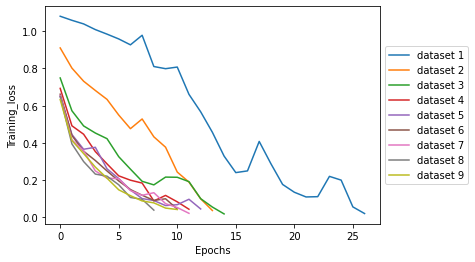

In [53]:
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))